In [ ]:
%%capture
!pip install neptune-client psutil
!git clone https://github.com/Cho-D-YoungRae/URP_PD.git
%cd URP_PD

In [ ]:
import dataset
import object_detection
from utils import *

import os
import argparse
from PIL import Image
import numpy as np
import json

from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch
import torchvision.transforms

data_dir = '/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using <{device}> device")

Using <cpu> device


In [ ]:
# ====== constants ======#
label_map = {'background': 0, 'person': 1}
rev_label_map = {v: k for k, v in label_map.items()} 

## setting

In [ ]:
from torch.backends import cudnn
import random

cudnn.benchmark = True

# ====== Random Seed Initialization ====== #
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.baselineID = 27

# ====== Dataset ====== #
args.ch_option = {'num_ch': 1,
                  'img_type': 'lwir',
                  'one_ch_option': 'mean'}

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
if args.ch_option.get('num_ch') == 1:
    if args.ch_option.get('one_ch_option') == 'mean':
        mean = sum(mean) / len(mean)
        std = sum(std) / len(std)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(300,300)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/2021.summer_URP/PD/checkpoint'
checkpoint_path = os.path.join(checkpoint_dir,
                               str(args.baselineID)+'.pth.tar')

checkpoint = torch.load(checkpoint_path, map_location=device)
save_epoch = checkpoint['epoch']
print(f'Loaded checkpoint from epoch {save_epoch}\n')
model = checkpoint['model']
model = model.train()

Loaded checkpoint from epoch 100



## Segmentation performance

In [51]:
img_id = 'set01/V001/I00063'
ann_path = os.path.join(data_dir, 'annotation_json', img_id+'.json')
img_dir, img_name = os.path.split(img_id)
img_path = os.path.join(data_dir, 'images', img_dir, 'lwir', img_name+'.jpg')

In [52]:
with open(ann_path, 'r') as j:
    anns = json.load(j)

In [53]:
anns

{'annotation': [{'bbox': [87, 229, 129, 331],
   'category_id': 1,
   'id': 0,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [114, 232, 151, 325],
   'category_id': 1,
   'id': 1,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [257, 232, 292, 315],
   'category_id': 1,
   'id': 2,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [281, 250, 310, 319],
   'category_id': 1,
   'id': 3,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [312, 243, 368, 375],
   'category_id': 1,
   'id': 4,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [376, 241, 406, 315],
   'category_id': 1,
   'id': 5,
   'image_id': 63,
   'is_crowd': 0},
  {'bbox': [461, 228, 496, 279],
   'category_id': -1,
   'id': 6,
   'image_id': 63,
   'is_crowd': 0}],
 'image': {'file_name': 'I00063', 'height': 512, 'id': 63, 'width': 640}}

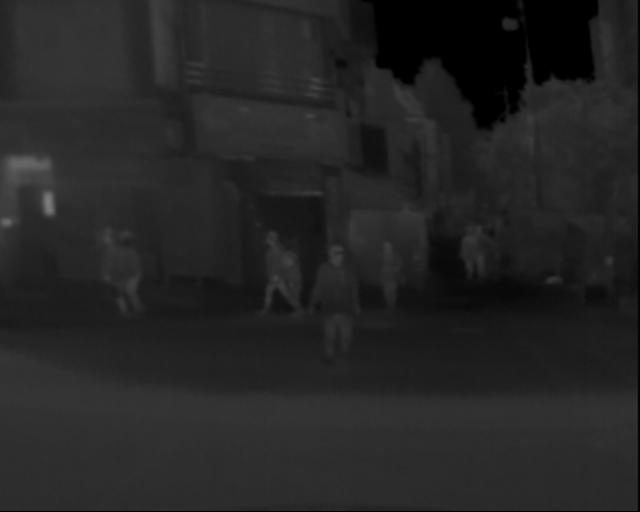

In [54]:
image = Image.open(img_path).convert('L')
image

In [55]:
img_size = (image.height, image.width)
pseudo_gt = torch.zeros(img_size)
for ann in anns['annotation']:
    x_min, y_min, x_max, y_max = ann['bbox']
    pseudo_gt[y_min:y_max+1, x_min:x_max+1] = 1

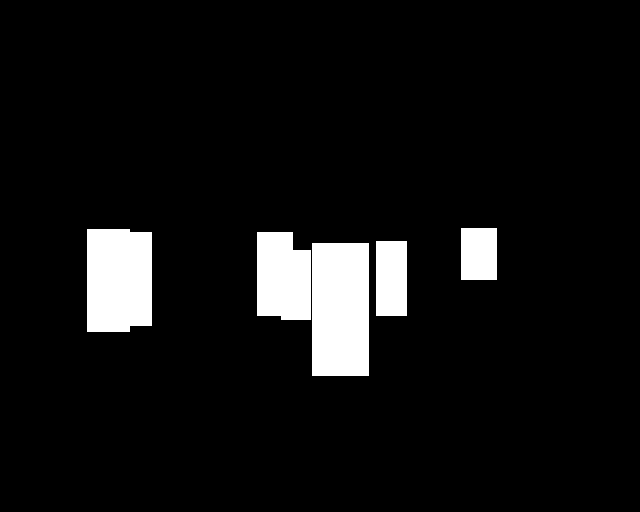

In [56]:
TF.to_pil_image(pseudo_gt)

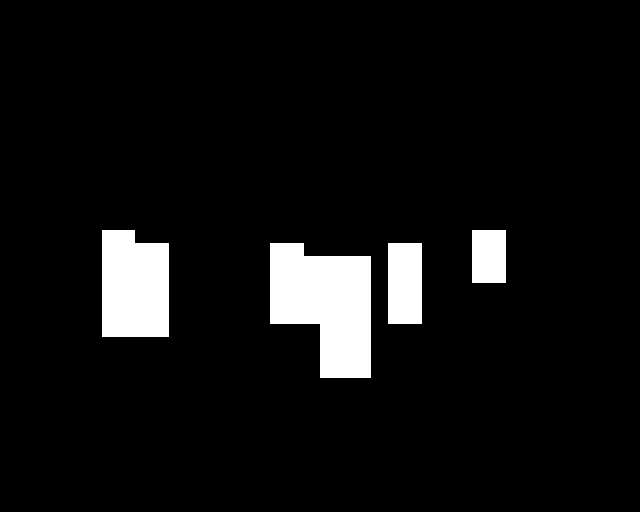

In [57]:
down_size = (38, 38)
down_gt = F.interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = F.interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

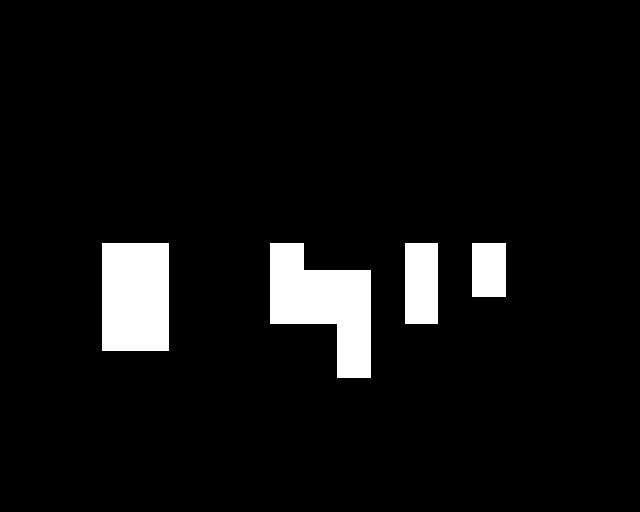

In [58]:
down_size = (19, 19)
down_gt = F.interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = F.interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

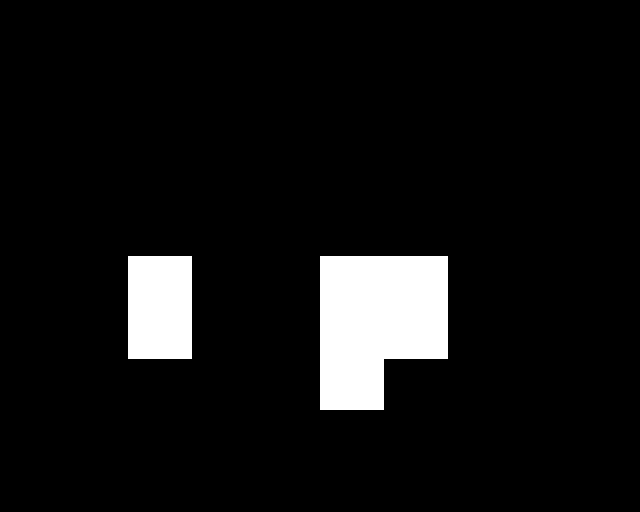

In [59]:
down_size = (10, 10)
down_gt = F.interpolate(pseudo_gt.unsqueeze(0).unsqueeze(0), size=down_size)
down_gt = F.interpolate(down_gt, size=img_size)
TF.to_pil_image(down_gt[0][0])

## segmentation

In [60]:
input = preprocess(image).to(device)
predicted_locs, predicted_scores, segmentations = model(input.unsqueeze(0))

In [61]:
for i in range(len(segmentations)):
    segmentations[i] = F.softmax(segmentations[i], dim=1)

In [62]:
segmentations[0].max()

tensor(0.9621, grad_fn=<MaxBackward1>)

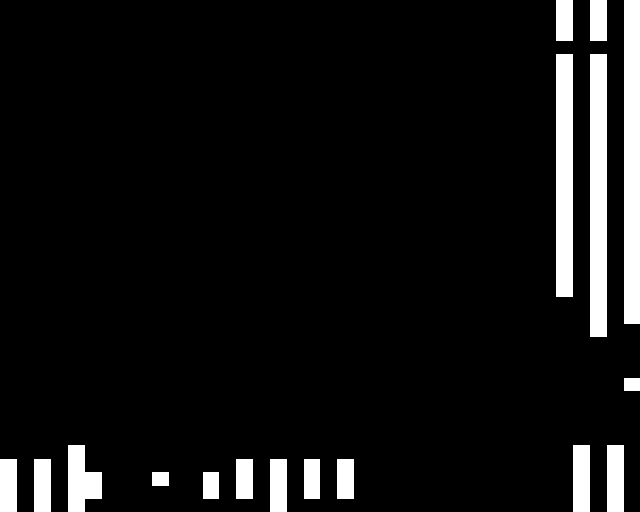

In [63]:
segmentation = torch.argmax(segmentations[0], dim=1).float()
segmentation.size()
segmentation = F.interpolate(segmentation.unsqueeze(0), size=img_size)
TF.to_pil_image(segmentation[0])

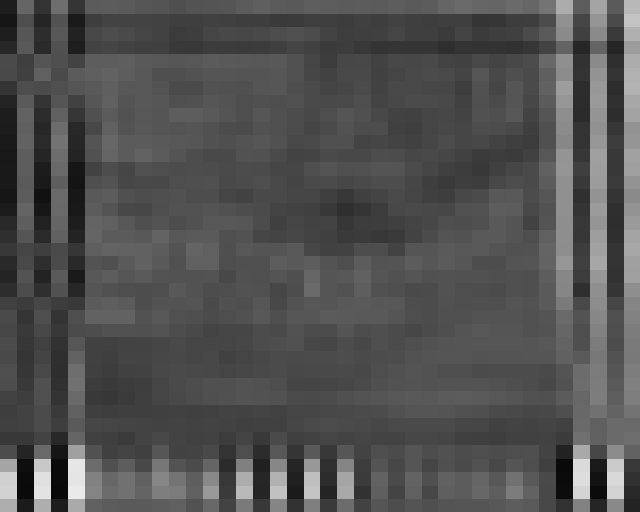

In [64]:
segmentation = segmentations[0]
segmentation = F.interpolate(segmentation, size=img_size)
TF.to_pil_image(segmentation[0][1])

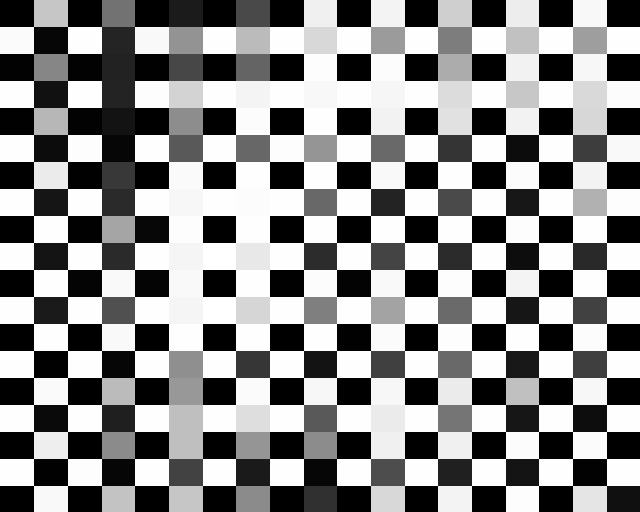

In [65]:
segmentation = segmentations[1]
segmentation = F.interpolate(segmentation, size=img_size)
TF.to_pil_image(segmentation[0][1])